In [1]:
import os, dicom2jpg, numpy as np
from glob import glob; from PIL import Image
from torch.utils.data import random_split, Dataset, DataLoader

class CustomDataset(Dataset):
    
    def __init__(self, root, n_cls, transformations = None):
        
        self.transformations = transformations
        self.im_paths = [im_path for im_path in sorted(glob(f"{root}/*/*")) if "jpg" in im_path]
        
        self.classes, count = {}, 0
        for idx, im_path in enumerate(self.im_paths):
            if len(self.classes) == n_cls: break
            class_name = self.get_class(im_path)
            if class_name not in self.classes: self.classes[class_name] = count; count += 1            
        
    def get_class(self, path): return os.path.dirname(path).split("/")[-1]
    
    def __len__(self): return len(self.im_paths)

    def __getitem__(self, idx):
        
        im_path = self.im_paths[idx]
        im = Image.open(im_path)
        gt = self.classes[self.get_class(im_path)]
        
        if self.transformations is not None: im = self.transformations(im)
        
        return im, gt
    
ds = CustomDataset(root = "files", n_cls = 3)

/home/ubuntu/anaconda3/envs/speed/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from torchvision import transforms as T

def get_dls(root, transformations, bs, n_cls, split = [0.8, 0.1, 0.1], ns = 4):
    
    ds = CustomDataset(root = root, transformations = transformations, n_cls = n_cls)
    ds_len = len(ds)
    tr_len = int(ds_len * split[0]); val_len = int(ds_len * split[1]); ts_len = ds_len - tr_len - val_len
    
    tr_ds, val_ds, ts_ds = random_split(ds, [tr_len, val_len, ts_len])
    
    tr_dl, val_dl, ts_dl = DataLoader(tr_ds, batch_size = bs, shuffle = True, num_workers = ns), DataLoader(val_ds, batch_size = bs, shuffle = False, num_workers = ns), DataLoader(ts_ds, batch_size = 1, shuffle = False, num_workers = ns)
    
    return tr_dl, val_dl, ts_dl, ds.classes

mean, std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
tfs = T.Compose([T.Resize((224, 224)), T.ToTensor(), T.Normalize(mean = mean, std = std)])
tr_dl, val_dl, ts_dl, classes = get_dls(root = "files", transformations = tfs, bs = 4, n_cls = 3)

print(len(tr_dl)); print(len(val_dl)); print(len(ts_dl)); print(classes)

52
7
27
{'aneurysm': 0, 'cancer': 1, 'tumor': 2}


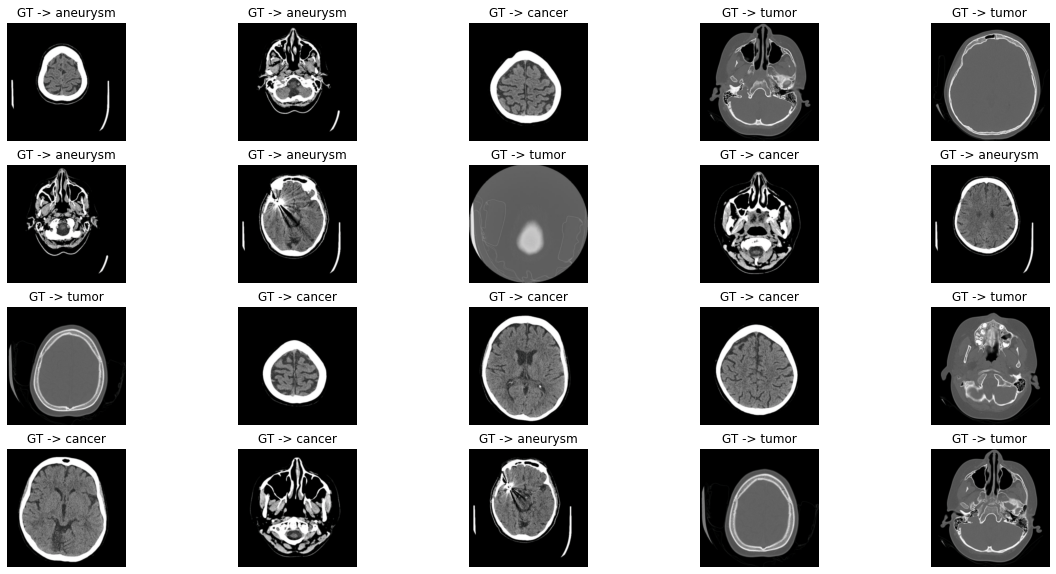

In [3]:
import random
from matplotlib import pyplot as plt

def tensor_2_im(t, t_type = "rgb"):
    
    gray_tfs = T.Compose([T.Normalize(mean = [ 0.], std = [1/0.5]), T.Normalize(mean = [-0.5], std = [1])])
    rgb_tfs = T.Compose([T.Normalize(mean = [ 0., 0., 0. ], std = [ 1/0.229, 1/0.224, 1/0.225 ]), T.Normalize(mean = [ -0.485, -0.456, -0.406 ], std = [ 1., 1., 1. ])])
    
    invTrans = gray_tfs if t_type == "gray" else rgb_tfs 
    
    return (invTrans(t) * 255).detach().squeeze().cpu().permute(1,2,0).numpy().astype(np.uint8) if t_type == "gray" else (invTrans(t) * 255).detach().cpu().permute(1,2,0).numpy().astype(np.uint8)

def visualize(data, n_ims, rows, cmap = None, cls_names = None):
    
    assert cmap in ["rgb", "gray"], "Rasmni oq-qora yoki rangli ekanini aniqlashtirib bering!"
    if cmap == "rgb": cmap = "viridis"
    
    plt.figure(figsize = (20, 10))
    indekslar = [random.randint(0, len(data) - 1) for _ in range(n_ims)]
    for idx, indeks in enumerate(indekslar):
        
        im, gt = data[indeks]
        # Start plot
        plt.subplot(rows, n_ims // rows, idx + 1)
        if cmap: plt.imshow(tensor_2_im(im, cmap), cmap=cmap)
        else: plt.imshow(tensor_2_im(im))
        plt.axis('off')
        if cls_names is not None: plt.title(f"GT -> {cls_names[int(gt)]}")
        else: plt.title(f"GT -> {gt}")
            
visualize(tr_dl.dataset, 20, 4, "rgb", list(classes.keys()))

In [4]:
import timm, torch
m = timm.create_model("resnet18", pretrained = True, num_classes = len(classes))  
def train_setup(m): return m.to("cuda:3"), 10, "cuda:3", torch.nn.CrossEntropyLoss(), torch.optim.Adam(params = m.parameters(), lr = 3e-4)
m, epochs, device, loss_fn, optimizer = train_setup(m)

In [5]:
from tqdm import tqdm

print("Start training...")
best_acc = 0
for epoch in range(epochs):
    
    epoch_loss, epoch_acc, total = 0, 0, 0
    for idx, batch in tqdm(enumerate(tr_dl)):
        ims, gts = batch
        ims, gts = ims.to(device), gts.to(device)
        
        total += ims.shape[0]
        
        preds = m(ims)
        pred_cls = torch.argmax(preds.data, dim = 1)
        loss = loss_fn(preds, gts)
        
        epoch_acc += (pred_cls == gts).sum().item()
        epoch_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print(f"{epoch + 1}-epoch train process is completed!")
    print(f"{epoch + 1}-epoch train loss -> {(epoch_loss / len(tr_dl)):.3f}")
    print(f"{epoch + 1}-epoch train accuracy -> {(epoch_acc / total):.3f}")
    
    m.eval()
    with torch.no_grad():
        val_epoch_loss, val_epoch_acc, val_total = 0, 0, 0
        for idx, batch in enumerate(val_dl):
            ims, gts = batch
            ims, gts = ims.to(device), gts.to(device)
            val_total += ims.shape[0]

            preds = m(ims)
            loss = loss_fn(preds, gts)
            _, pred_cls = torch.max(preds.data, dim = 1)
            val_epoch_acc += (pred_cls == gts).sum().item()
            val_epoch_loss += loss.item()
        
        val_acc = val_epoch_acc / val_total
        print(f"{epoch + 1}-epoch validation process is completed!")
        
        print(f"{epoch + 1}-epoch validation loss -> {(val_epoch_loss / len(val_dl)):.3f}")
        print(f"{epoch + 1}-epoch validation accuracy -> {val_acc:.3f}")
        
        if val_acc > best_acc:
            os.makedirs("saved_models", exist_ok=True)
            best_acc = val_acc
            torch.save(m.state_dict(), f"saved_models/med_best_model_{val_acc:.3f}.pth")

Start training...


52it [00:04, 10.80it/s]

1-epoch train process is completed!
1-epoch train loss -> 0.364
1-epoch train accuracy -> 0.855


1-epoch validation process is completed!
1-epoch validation loss -> 0.028
1-epoch validation accuracy -> 1.000


52it [00:01, 35.65it/s]

2-epoch train process is completed!
2-epoch train loss -> 0.493
2-epoch train accuracy -> 0.855


2-epoch validation process is completed!
2-epoch validation loss -> 0.081
2-epoch validation accuracy -> 0.960


52it [00:01, 36.85it/s]

3-epoch train process is completed!
3-epoch train loss -> 0.516
3-epoch train accuracy -> 0.889


3-epoch validation process is completed!
3-epoch validation loss -> 0.164
3-epoch validation accuracy -> 0.920


52it [00:01, 36.85it/s]

4-epoch train process is completed!
4-epoch train loss -> 0.605
4-epoch train accuracy -> 0.720


4-epoch validation process is completed!
4-epoch validation loss -> 0.536
4-epoch validation accuracy -> 0.640


52it [00:01, 36.04it/s]

5-epoch train process is completed!
5-epoch train loss -> 0.450
5-epoch train accuracy -> 0.783


5-epoch validation process is completed!
5-epoch validation loss -> 0.101
5-epoch validation accuracy -> 0.960


52it [00:01, 37.75it/s]

6-epoch train process is completed!
6-epoch train loss -> 0.876
6-epoch train accuracy -> 0.681


6-epoch validation process is completed!
6-epoch validation loss -> 0.549
6-epoch validation accuracy -> 0.920


52it [00:01, 36.84it/s]

7-epoch train process is completed!
7-epoch train loss -> 0.303
7-epoch train accuracy -> 0.908


7-epoch validation process is completed!
7-epoch validation loss -> 0.072
7-epoch validation accuracy -> 0.960


52it [00:01, 37.51it/s]

8-epoch train process is completed!
8-epoch train loss -> 0.192
8-epoch train accuracy -> 0.971


8-epoch validation process is completed!
8-epoch validation loss -> 0.190
8-epoch validation accuracy -> 0.960


52it [00:01, 36.40it/s]

9-epoch train process is completed!
9-epoch train loss -> 0.269
9-epoch train accuracy -> 0.923


9-epoch validation process is completed!
9-epoch validation loss -> 0.059
9-epoch validation accuracy -> 0.960


52it [00:01, 35.86it/s]

10-epoch train process is completed!
10-epoch train loss -> 0.108
10-epoch train accuracy -> 0.986


10-epoch validation process is completed!
10-epoch validation loss -> 0.009
10-epoch validation accuracy -> 1.000


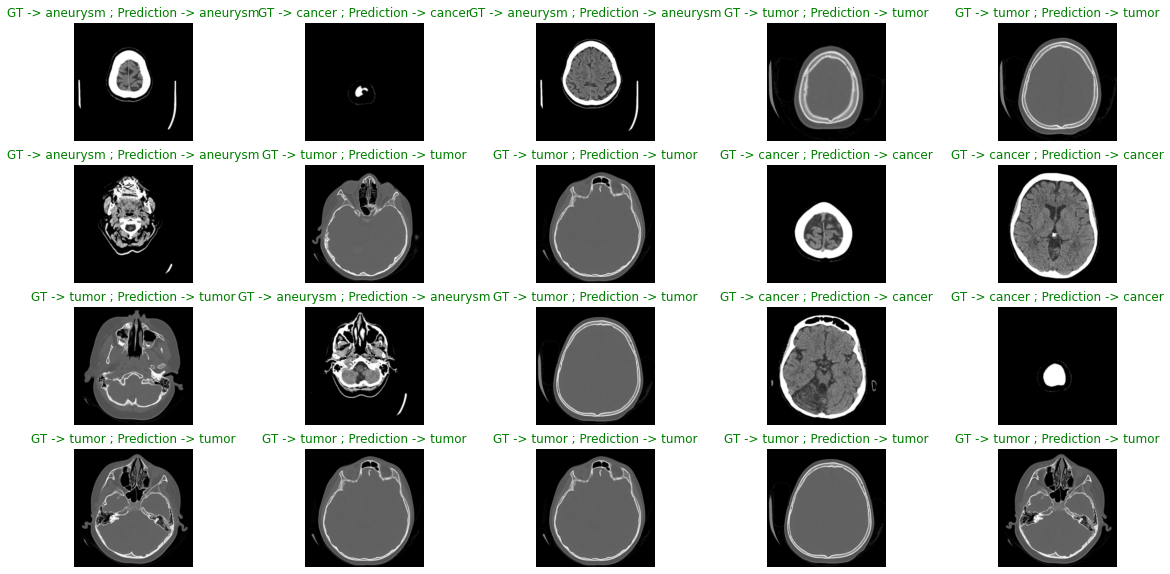

In [6]:
def inference(model, device, test_dl, num_ims, row, cls_names = None):
    
    preds, images, lbls = [], [], []
    for idx, data in enumerate(test_dl):
        im, gt = data
        im, gt = im.to(device), gt.to(device)
        _, pred = torch.max(model(im), dim = 1)
        images.append(im)
        preds.append(pred.item())
        lbls.append(gt.item())
    
    plt.figure(figsize = (20, 10))
    indekslar = [random.randint(0, len(images) - 1) for _ in range(num_ims)]
    for idx, indeks in enumerate(indekslar):
        
        im = images[indeks].squeeze()
        # Start plot
        plt.subplot(row, num_ims // row, idx + 1)
        plt.imshow(tensor_2_im(im), cmap='gray')
        plt.axis('off')
        if cls_names is not None: plt.title(f"GT -> {cls_names[int(lbls[indeks])]} ; Prediction -> {cls_names[int(preds[indeks])]}", color=("green" if {cls_names[int(lbls[indeks])]} == {cls_names[int(preds[indeks])]} else "red"))
        else: plt.title(f"GT -> {gt} ; Prediction -> {pred}")

inference(m, device, ts_dl, 20, 4, list(classes.keys()))